In [1]:
from ConvexNN import ConvexVAE
from ConvexNN.models import ConvexReluMLP, NonConvexReLU
from ConvexNN.utils import sample_gate_vectors

In [2]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torchinfo import summary

In [3]:
dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 1024
latent_dim = 200

lr = 1e-3

epochs = 30

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [5]:
encoder = ConvexVAE.Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_classes=10)
# decoder = ConvexVAE.Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim, num_classes=10)
# decoder = NonConvexReLU(d=latent_dim, p=hidden_dim, c=x_dim, num_classes=0)

decoder = ConvexReluMLP(d=latent_dim, num_neurons=hidden_dim, output_dims=784, num_classes=10)

model = ConvexVAE.Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
# summary(decoder, input_size=(batch_size, 110))

In [6]:
from torch.optim import Adam, SGD

BCE_loss = nn.MSELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = BCE_loss(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = SGD(model.parameters(), lr=lr)

In [7]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        y = y.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x, y)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  0.010028541070193003
	Epoch 2 complete! 	Average Loss:  0.0027519782907477206
	Epoch 3 complete! 	Average Loss:  0.0020791733645537064
	Epoch 4 complete! 	Average Loss:  0.0017720362459478871
	Epoch 5 complete! 	Average Loss:  0.0015834667982661068
	Epoch 6 complete! 	Average Loss:  0.001448211897295186
	Epoch 7 complete! 	Average Loss:  0.0013482058721163833
	Epoch 8 complete! 	Average Loss:  0.0012689899099689096
	Epoch 9 complete! 	Average Loss:  0.0012042686040940787
	Epoch 10 complete! 	Average Loss:  0.0011505609867668311
	Epoch 11 complete! 	Average Loss:  0.0011048103963492908
	Epoch 12 complete! 	Average Loss:  0.0010657848083166924
	Epoch 13 complete! 	Average Loss:  0.0010318861027343047
	Epoch 14 complete! 	Average Loss:  0.001002266496196016
	Epoch 15 complete! 	Average Loss:  0.0009763657857659265
	Epoch 16 complete! 	Average Loss:  0.0009530813341496982
	Epoch 17 complete! 	Average Loss:  0.0009325580235464943
	Epo

In [8]:
import matplotlib.pyplot as plt

In [9]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, y) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        y = y.to(DEVICE)
        
        x_hat, _, _ = model(x, y)


        break

  0%|                                                                                                                                                                                                                                                                                                                                                                                                        | 0/100 [00:01<?, ?it/s]


In [10]:
def show_image(x, idx):
    x = x.view(x.shape[0], 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

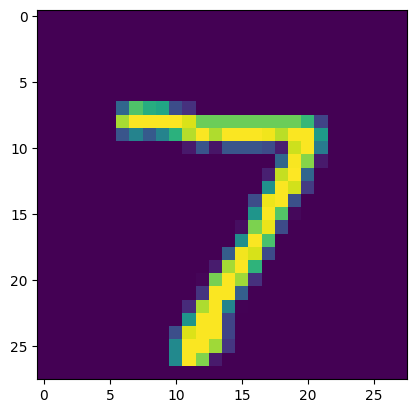

In [11]:
show_image(x, idx=0)

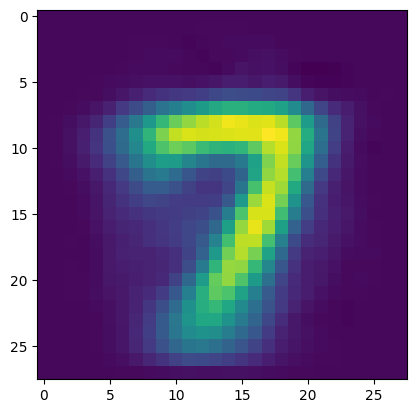

In [15]:
show_image(x_hat, idx=0)

In [13]:
with torch.no_grad():
    noise = torch.randn(10, latent_dim).to(DEVICE)
    label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(DEVICE)
    generated_images = decoder(noise, label=label)

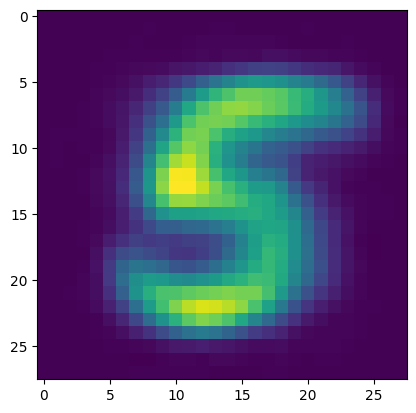

In [18]:
show_image(generated_images, idx=5)

In [ ]:
torch.save(encoder.state_dict(), "encoder.pt")